In [3]:
%store -r __ipy
%store -r __da
%store -r __ml

In [4]:
__ipy

Helper ipython script loaded


In [5]:
__da

Basic Data Analysis tools was loaded


In [6]:
__ml

In [6]:
def ts_features(train1, column_sort, column_value, settings):
    X=extract_features(train1, 
                     column_id=KEY_NAME,
                     column_sort=column_sort,
                     column_value=column_value,
                     default_fc_parameters=settings,
                     impute_function= impute,
                     disable_progressbar=True,
                     show_warnings=True)
    return X

def generate_ts_features(X_train, y_col_name, time_col, settings):
    start = time.time()
    features = ts_features(X_train, time_col, y_col_name, settings)
    features = reduce_mem_usage(features)
    X_filtered = features.replace([np.inf, -np.inf, np.nan], 0)
    
    end = time.time()
    print("Time",end - start)
    
    ####
    ###
    
    return X_filtered


def generate_and_merge(X_train, X_test, settings):
    features = generate_ts_features(X_train, 'meter_reading_log1p', 'hour_datetime', settings)
    
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test

folds = 6
@telegram_sender(token=TELEGRAM_API_KEY, chat_id=CHAT_ID)
def lgbm_cross_validation(params):
    seed = 42
    
    kf = KFold(n_splits=folds)
    total_loss = []
    
    for train_index, val_index in kf.split(full_train_df):
        
        train_X = full_train_df.loc[train_index, [*feat_cols, 'meter_reading_log1p']].reset_index(drop=True)
        val_X = full_train_df.loc[val_index, feat_cols].reset_index(drop=True)
        train_y = target.iloc[train_index]
        val_y = target.iloc[val_index]
        
        ###
        
        train_X, val_X = generate_and_merge(train_X, val_X, settings)
        
        ###
        train_X.drop('meter_reading_log1p', axis=1, inplace=True)
        ####
        
        ####
        
        lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)
        lgb_eval = lgb.Dataset(val_X, val_y, categorical_feature=categoricals)
        lgbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=500,
                    valid_sets=(lgb_train, lgb_eval),
                    early_stopping_rounds=100,
                    verbose_eval = 0)
        
        pred_y = lgbm.predict(val_X)
        mse = np.sqrt(mean_squared_error((val_y), (pred_y)))
        total_loss.append(mse)

    return {'loss': np.mean(total_loss), 'status': STATUS_OK, 'params': params }

def optimize_lgbm(max_evals=1000):
    space = {
        'metric': {'rmse'},
        'num_leaves': scope.int(hp.quniform('num_leaves', 30, 150, 1)),
        'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
        'min_data_in_leaf': scope.int(hp.qloguniform('min_data_in_leaf', 0, 6, 1)),
        'lambda_l1': hp.choice('lambda_l1', [0, hp.loguniform('lambda_l1_positive', -16, 2)]),
        'lambda_l2': hp.choice('lambda_l2', [0, hp.loguniform('lambda_l2_positive', -16, 2)]),
        'min_child_weight': hp.loguniform('min_child_weight', -16, 5), #also aliases to min_sum_hessian
        'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
        'colsample_bytree': hp.uniform('colsample_by_tree', 0.6, 1.0),
    }
    
    trials = Trials()
    best = fmin(fn=lgbm_cross_validation,
                space=space,
                algo=tpe.suggest,
                max_evals=max_evals,
                trials=trials,
                verbose= 1)

    # find the trial with lowest loss value. this is what we consider the best one
    idx = np.argmin(trials.losses())
    print(idx)

    print(trials.trials[idx])
    # these should be the training parameters to use to achieve the best score in best trial
    params = trials.trials[idx]["result"]["params"]
    
    print(params)
    return params

In [15]:
import  time

In [ ]:
import json
with open(models + 'year_settings.json', 'r') as json_file:
    settings = json.loads(json_file.read())

def generate_and_merge(X_train, X_test, settings):
    features = generate_ts_features(X_train, 'meter_reading_log1p', 'dayofyear_datetime', settings)
    X_train = X_train.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    if np.any(X_test):    
        X_test = X_test.merge(features, how='left', left_on=KEY_NAME, right_on='id')
    
    return X_train, X_test, features


def read_features(test=True):
    #test_df.to_pickle(root + "test_features.pkl")
    train_df = pd.read_pickle(root + "train_features.pkl")
    full_train_df = train_df.drop('timestamp', axis=1)
    full_train_df = full_train_df.reset_index(drop=True)
    train_X = full_train_df[[*feat_cols, 'meter_reading_log1p']].reset_index(drop=True)
    train_y = full_train_df['meter_reading_log1p']
    
    if test:
        test_df = pd.read_pickle(root + "test_features.pkl")
        test_X.drop('timestamp', axis=1, inplace=True)
        test_X = test_df

    ## Feature generation
    train_X, test_X, tsfresh_features = generate_and_merge(train_X, None, settings)
    ##
    
    train_X.drop('meter_reading_log1p', axis=1, inplace=True)
    return train_X, test_X, tsfresh_features

In [16]:
train_X, test_X, tsfresh_features = read_features(test=True)

Mem. usage decreased to  0.26 Mb (73.1% reduction)
Time 299.9200780391693


In [7]:
evals_result = {} 

@telegram_sender(token=TELEGRAM_API_KEY, chat_id=CHAT_ID)
def model_train(params):
    seed = 42
    lgb_train = lgb.Dataset(train_X, train_y, categorical_feature=categoricals)

    lgbm = lgb.train(params,
                lgb_train,
                num_boost_round=300,
                valid_sets=(lgb_train),
                early_stopping_rounds=100,
                evals_result = evals_result,
                verbose_eval = 10)
    
    joblib.dump(lgbm, models + 'lgbm.joblib')
    return lgbm


def load_model():
    lgbm = joblib.load(models + 'lgbm.joblib')
    return lgbm

In [29]:
def batch_prediction(model, samples, n = 100):
    kfold = KFold(n)
    agg = []
    
    for train_index, test_index in tqdm(kfold.split(samples)):
        preds = model.predict(samples.loc[test_index, :])
        agg += preds.tolist()
        
    return agg

def create_submission(model, test_data, submission_name, send_submission=False, message="Enter model name"):
    preds = batch_prediction(model, test_data)
    
    submission_df = pd.DataFrame() 
    submission_df['row_id'] = np.arange(len(preds))
    submission_df['meter_reading'] = np.exp(preds)
    submission_df.to_csv(submission + submission_name, index=False)
   
    if send_submission:
        !kaggle competitions submit -c ashrae-energy-prediction -f {submission_name} -m {message}
        

create_submission(lgbm, test_X, 'lgbm_first', True, 'lgbm')

Traceback (most recent call last):
  File "c:\users\maksym_suprunenko\appdata\local\continuum\miniconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\maksym_suprunenko\appdata\local\continuum\miniconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\Maksym_Suprunenko\AppData\Local\Continuum\miniconda3\Scripts\kaggle.exe\__main__.py", line 4, in <module>
  File "c:\users\maksym_suprunenko\appdata\local\continuum\miniconda3\lib\site-packages\kaggle\__init__.py", line 23, in <module>
    api.authenticate()
  File "c:\users\maksym_suprunenko\appdata\local\continuum\miniconda3\lib\site-packages\kaggle\api\kaggle_api_extended.py", line 149, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in C:\Users\Maksym_Suprunenko\.kaggle. Or use the environment method.


In [28]:
lgbm = model_train({'colsample_bytree': 0.6822560141727592,
 'lambda_l1': 0,
 'lambda_l2': 0.0002740951720687087,
 'learning_rate': 0.026270661708149894,
 'metric': {'rmse'},
 'min_child_weight': 0.7119717355682591,
 'min_data_in_leaf': 381,
 'num_leaves': 98,
 'reg_alpha': 0.4682446847511589,
 'reg_lambda': 0.6062162687310869})

Training until validation scores don't improve for 100 rounds
[10]	training's rmse: 1.76698
[20]	training's rmse: 1.53317
[30]	training's rmse: 1.37205
[40]	training's rmse: 1.26127
[50]	training's rmse: 1.18141
[60]	training's rmse: 1.1226
[70]	training's rmse: 1.07919
[80]	training's rmse: 1.0475
[90]	training's rmse: 1.01907
[100]	training's rmse: 0.987871
[110]	training's rmse: 0.962417
[120]	training's rmse: 0.942382
[130]	training's rmse: 0.925203
[140]	training's rmse: 0.907178
[150]	training's rmse: 0.889852
[160]	training's rmse: 0.872631
[170]	training's rmse: 0.857679
[180]	training's rmse: 0.844562
[190]	training's rmse: 0.830591
[200]	training's rmse: 0.818647
[210]	training's rmse: 0.807295
[220]	training's rmse: 0.797371
[230]	training's rmse: 0.787665
[240]	training's rmse: 0.780123
[250]	training's rmse: 0.772404
[260]	training's rmse: 0.766
[270]	training's rmse: 0.759562
[280]	training's rmse: 0.754937
[290]	training's rmse: 0.750245
[300]	training's rmse: 0.744361
D

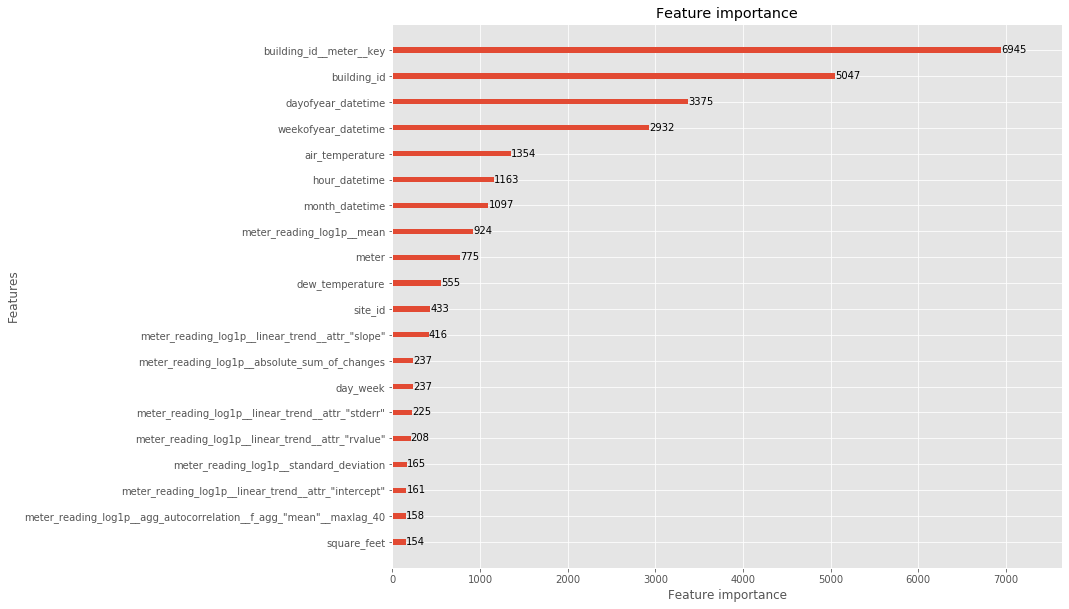

In [29]:
fig, ax = plt.subplots(figsize=(12,10))
ax = lgb.plot_importance(lgbm, max_num_features=20, ax=ax)
plt.show()

In [49]:
import operator

l = list(zip(train_X.columns, lgbm.feature_importance()))
l.sort(key=operator.itemgetter(1), reverse=True)
l

[('building_id__meter__key', 6945),
 ('building_id', 5047),
 ('dayofyear_datetime', 3375),
 ('weekofyear_datetime', 2932),
 ('air_temperature', 1354),
 ('hour_datetime', 1163),
 ('month_datetime', 1097),
 ('meter_reading_log1p__mean', 924),
 ('meter', 775),
 ('dew_temperature', 555),
 ('site_id', 433),
 ('meter_reading_log1p__linear_trend__attr_"slope"', 416),
 ('day_week', 237),
 ('meter_reading_log1p__absolute_sum_of_changes', 237),
 ('meter_reading_log1p__linear_trend__attr_"stderr"', 225),
 ('meter_reading_log1p__linear_trend__attr_"rvalue"', 208),
 ('meter_reading_log1p__standard_deviation', 165),
 ('meter_reading_log1p__linear_trend__attr_"intercept"', 161),
 ('meter_reading_log1p__agg_autocorrelation__f_agg_"mean"__maxlag_40', 158),
 ('square_feet', 154),
 ('sea_level_pressure', 147),
 ('meter_reading_log1p__c3__lag_1', 143),
 ('meter_reading_log1p__c3__lag_2', 119),
 ('meter_reading_log1p__mean_change', 105),
 ('meter_reading_log1p__count_above_mean', 99),
 ('meter_reading_log1

Plotting metrics recorded during training...


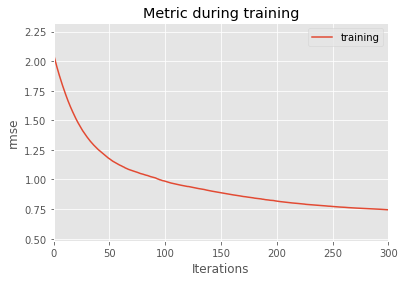

In [30]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()